<a href="https://colab.research.google.com/github/TiagoFerreira-lab/-CNN-Convolutional-neural-network-/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load and pre process **data**

In [6]:
import os
import zipfile
from google.colab import drive
import gdown
# 📌 Step 1: Mount Google Drive
drive.mount('/content/drive')

# 📌 Step 2: Define Paths
animals_zip_path = "/content/animals10.zip"
holdout_zip_path = "/content/holdout.zip"
#


# Download the datasets
gdown.download(id="1Ysk97pNfAS3xZJWsYgaQK0jtjfrZP6Qw", output=animals_zip_path, quiet=False)
gdown.download(id="13Rc0KxfhJyUPOB7H__pFs5X89_VSg8oW", output=holdout_zip_path, quiet=False)
 # Verify files
print(f":marca_de_verificação_branca: Training dataset saved at: {animals_zip_path}")
print(f":marca_de_verificação_branca: Holdout dataset saved at: {holdout_zip_path}")

# where to go
animals_extract_to = "/content/Animals-10/"
holdout_extract_to = "/content/Holdout-10/"

# 📌 Step 3: Extract the ZIP Files
if not os.path.exists(animals_extract_to):
    with zipfile.ZipFile(animals_zip_path, 'r') as zip_ref:
        zip_ref.extractall(animals_extract_to)
    print("✅ Extracted training dataset.")

if not os.path.exists(holdout_extract_to):
    with zipfile.ZipFile(holdout_zip_path, 'r') as zip_ref:
        zip_ref.extractall(holdout_extract_to)
    print("✅ Extracted holdout dataset.")

# 📌 Step 4: Fix Dataset Paths (Point to `raw-img/`)
animals_dataset_path = "/content/Animals-10/animals10/raw-img/"
holdout_dataset_path = "/content/Holdout-10/holdout/raw-img/"

# 📌 Step 5: Check Folder Structure
print("📂 Training Dataset Categories:", os.listdir(animals_dataset_path))
print("📂 Holdout Dataset Categories:", os.listdir(holdout_dataset_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From (original): https://drive.google.com/uc?id=1Ysk97pNfAS3xZJWsYgaQK0jtjfrZP6Qw
From (redirected): https://drive.google.com/uc?id=1Ysk97pNfAS3xZJWsYgaQK0jtjfrZP6Qw&confirm=t&uuid=10cf1633-9b6e-4d7b-911e-bb349b024e1b
To: /content/animals10.zip
100%|██████████| 564M/564M [00:03<00:00, 180MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=13Rc0KxfhJyUPOB7H__pFs5X89_VSg8oW
From (redirected): https://drive.google.com/uc?id=13Rc0KxfhJyUPOB7H__pFs5X89_VSg8oW&confirm=t&uuid=fae625ea-c0d5-4ce1-b4a4-676b2ebbc191
To: /content/holdout.zip
100%|██████████| 62.3M/62.3M [00:00<00:00, 160MB/s]


:marca_de_verificação_branca: Training dataset saved at: /content/animals10.zip
:marca_de_verificação_branca: Holdout dataset saved at: /content/holdout.zip
✅ Extracted training dataset.
✅ Extracted holdout dataset.
📂 Training Dataset Categories: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']
📂 Holdout Dataset Categories: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']


Check the folder structures

In [7]:
# List class folders
print("📂 Classes in Training Dataset:", os.listdir(animals_dataset_path))

# Print the class folders inside the holdout dataset
if os.path.exists(holdout_dataset_path):
    print("📂 Classes in Prediction (Holdout) Dataset:", os.listdir(holdout_dataset_path))
else:
    print("❌ Holdout dataset path not found:", holdout_dataset_path)


📂 Classes in Training Dataset: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']
📂 Classes in Prediction (Holdout) Dataset: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']


Normalize images, rescale and resize, train/validation split, one-hot encode is handled by imageDataGenerator

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images and apply data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize images (0-1 range)
    rotation_range=10,       # Rotate images slightly (15° instead of 30°)
    width_shift_range=0.1,   # Shift images horizontally slightly (10%)
    height_shift_range=0.1,  # Shift images vertically slightly (10%)
    horizontal_flip=True,    # Flip images horizontally
    validation_split=0.2     # 80% training, 20% validation
)

# Load training data
train_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),  # Resize images
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Dataset successfully loaded!")


Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.
Dataset successfully loaded!


Plot 5 random images

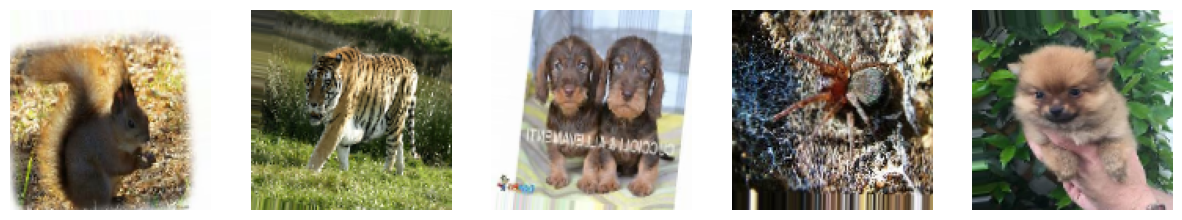

In [35]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(train_generator)

# Display first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis("off")
plt.show()

Define Model

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2


# 📌 Step 7: Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),


    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # L2 Regularization
    BatchNormalization(),
    Dropout(0.5),  # Prevent Overfitting

    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 output classes
])

In [40]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# 📌 Step 8: Compile the Model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Define callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Display model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 124, 124, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │              

 Total params: 11,146,058 (42.52 MB)

 Trainable params: 11,143,114 (42.51 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [49]:
import tensorflow.keras.backend as K
# Clear session to avoid conflicts
K.clear_session()

In [50]:
import time
# Start timer
start_time = time.time()


# 📌 Step 9: Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    verbose=1
)
#End timer
end_time = time.time()
# Calculate total training time
training_time = end_time - start_time
print(f":cronômetro: Total Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Epoch 1/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 104s 175ms/step - accuracy: 0.9090 - loss: 1.0443 - val_accuracy: 0.8405 - val_loss: 1.3351
Epoch 2/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 103s 175ms/step - accuracy: 0.9112 - loss: 1.0455 - val_accuracy: 0.8526 - val_loss: 1.3079
Epoch 3/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.9119 - loss: 1.0555 - val_accuracy: 0.8530 - val_loss: 1.2568
Epoch 4/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 103s 175ms/step - accuracy: 0.9181 - loss: 1.0167 - val_accuracy: 0.8454 - val_loss: 1.3103
Epoch 5/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 103s 175ms/step - accuracy: 0.9092 - loss: 1.0469 - val_accuracy: 0.8403 - val_loss: 1.2847
Epoch 6/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.9162 - loss: 1.0290 - val_accuracy: 0.8492 - val_loss: 1.3239
Epoch 7/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.9203 - loss: 1.0033 - val_accuracy: 0.8367 - val_loss: 1.3109
Epoch 8/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.9230 -

# Evaluate Model Performance on Validation Set (NOT on Holdout)

In [55]:
# Save model in TensorFlow format
model.save("model.h5")



148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.8450 - loss: 1.3095
Validation Accuracy: 84.69%
Validation Loss: 1.2913
Training Accuracy: 93.55%
Training Loss: 0.9175


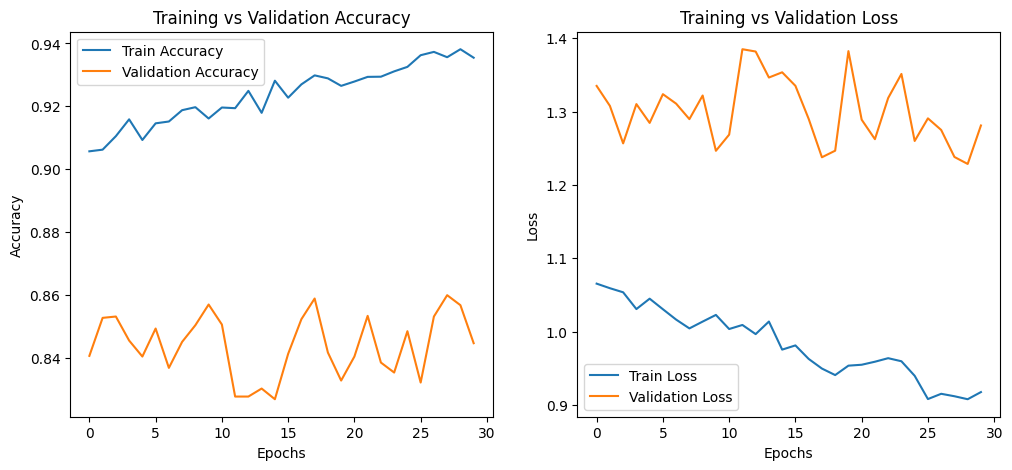

In [57]:
# 📌 Step 10: Evaluate the Model
loss, accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# Get final training accuracy & loss
train_accuracy = history.history['accuracy'][-1]  # Last epoch's accuracy
train_loss = history.history['loss'][-1]  # Last epoch's loss

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# 📌 Step 11: Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.show()

In [63]:
#label

# Get true labels and predicted labels
y_true = []
y_pred = []

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Predict on the entire validation set
for images, labels in val_generator:
    predictions = model.predict(images)  # Get predictions
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot encoding to label index
    y_pred.extend(np.argmax(predictions, axis=1))  # Get highest probability class

    if len(y_true) >= val_generator.samples:  # Stop when all validation images are processed
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

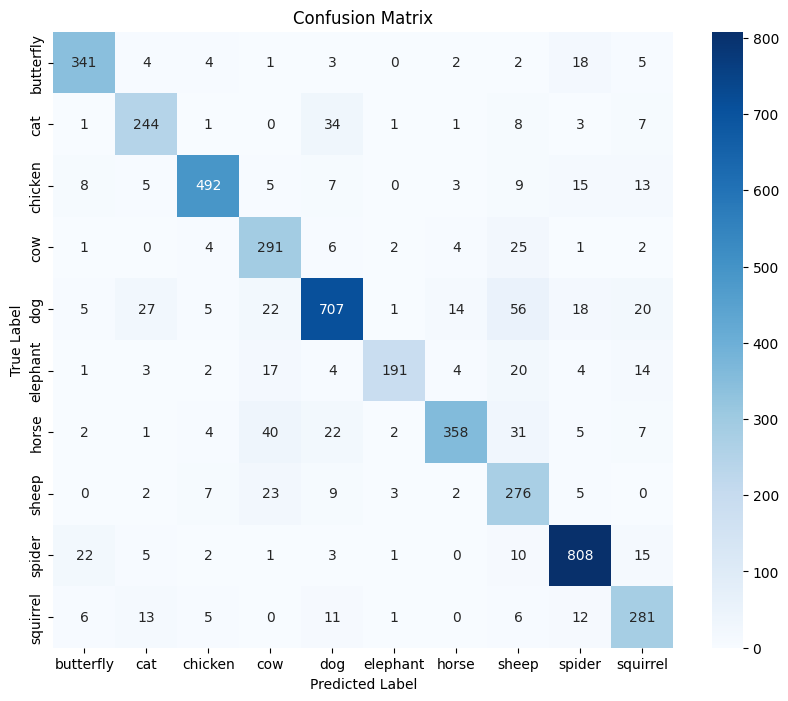

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Predict on Holdout Set (No Evaluation, Only Predictions)

In [66]:
from sklearn.metrics import precision_score

#precision_train = precision_score(y_true, y_pred, average='macro')
precision_test = precision_score(y_true, y_pred, average='macro')

#print(f'Train Balanced accuracy: {precision_train}')
print(f'Test Balanced accuracy: {precision_test}')

Test Balanced accuracy: 0.8294650692339249


In [67]:
from sklearn.metrics import recall_score

#recall_train = recall_score(y_train, y_train_pred, average='macro')
recall_test = recall_score(y_true, y_pred, average='macro')

#print(f'Train Recall Score: {recall_train}')
print(f'Test Recall Score: {recall_test}')

Test Recall Score: 0.8301814164844898


In [68]:
from sklearn.metrics import f1_score

#f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_true, y_pred, average='macro')

#print(f'Train F1 Score: {f1_train}')
print(f'Test F1 Score: {f1_test}')

Test F1 Score: 0.8242874919229507



✅ Making Predictions on Holdout Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━

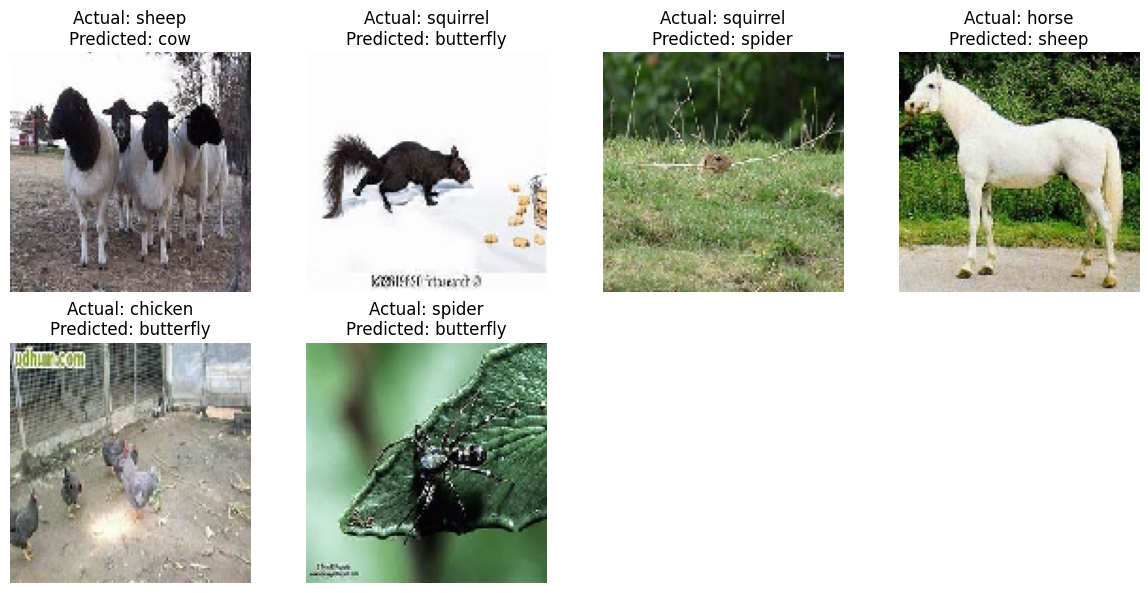

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

print("\n✅ Making Predictions on Holdout Set...")

class_labels = list(train_generator.class_indices.keys())

misclassified_images = []  # Store misclassified images

for class_name in os.listdir(holdout_dataset_path):
    class_folder = os.path.join(holdout_dataset_path, class_name)

    if os.path.isdir(class_folder):
        image_files = os.listdir(class_folder)

        for img_file in image_files[:5]:  # Predict on first 5 images
            if img_file.endswith(('.jpg', '.png', '.jpeg')):  # Ignore `.DS_Store`
                img_path = os.path.join(class_folder, img_file)

                # Load & Preprocess Image
                img = image.load_img(img_path, target_size=(128, 128))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array /= 255.0  # Normalize

                # Make Prediction
                prediction = model.predict(img_array)
                predicted_class = np.argmax(prediction)
                predicted_label = class_labels[predicted_class]

                # Check if misclassified
                if predicted_label != class_name:
                    misclassified_images.append((img_path, class_name, predicted_label))

# 📌 Step 2: Display Misclassified Images
if misclassified_images:
    print(f"\n❌ Found {len(misclassified_images)} Misclassified Images. Displaying...")

    plt.figure(figsize=(12, 6))
    for i, (img_path, actual, predicted) in enumerate(misclassified_images[:8]):  # Show first 8 misclassified images
        img = image.load_img(img_path, target_size=(128, 128))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No misclassified images found in the first few samples!")
